In [51]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
from glob import glob
import pandas as pd
import numpy as np

In [ ]:
nltk.download('punkt')

Load Model


In [3]:
model_name="facebook/bart-large-mnli"
device=0 if torch.cuda.is_available() else "cpu"

In [4]:
device

'cpu'

In [5]:
def load_model(device):
    theme_classifier = pipeline('zero-shot-classification', model=model_name, device=device)
    return theme_classifier

In [6]:
theme_classifier = load_model(device)

Device set to use cpu


In [7]:
theme_list = ['frienship','hope','sacrifice','battle','self development','betrayal','love','dialogue']

In [8]:
theme_classifier("I gave him a right hook to the jaw", theme_list, multi_label=True)

{'sequence': 'I gave him a right hook to the jaw',
 'labels': ['battle',
  'frienship',
  'self development',
  'sacrifice',
  'betrayal',
  'hope',
  'dialogue',
  'love'],
 'scores': [0.7831351161003113,
  0.25671330094337463,
  0.14653384685516357,
  0.14528131484985352,
  0.04410846531391144,
  0.016515610739588737,
  0.01102753821760416,
  0.0005920323892496526]}

Load Dataset

In [9]:
files = glob("../data/subtitles/*.ass")

In [10]:
files[:5]

['../data/subtitles\\001_LEG_English.ass',
 '../data/subtitles\\002_LEG_English.ass',
 '../data/subtitles\\003_LEG_English.ass',
 '../data/subtitles\\004_LEG_English.ass',
 '../data/subtitles\\005_LEG_English.ass']

In [11]:
with open(files[0], 'r')as file:
    lines=file.readlines()
    lines=lines[27:]
    lines=[",".join(line.split(",")[9:]) for line in lines]

In [12]:
lines[:2]

['A long time ago, a powerful demon fox\\Nappeared with nine tails.\n',
 'With its powerful tails,\n']

In [13]:
lines=[line.replace("\\N"," ") for line in lines]

In [14]:
lines[:2]

['A long time ago, a powerful demon fox appeared with nine tails.\n',
 'With its powerful tails,\n']

In [15]:
" ".join(lines[:10])

"A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can't let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known asâ€¦ the Fourth Hokage.\n Naruto!\n"

In [30]:
int(files[0].split("\\")[-1].split("_")[0])

1

In [37]:
def load_subtitles_dataset(dataset_path):
    subtitles_paths = glob(dataset_path+'/*.ass')
    scripts = []
    episode_num = []
    for path in subtitles_paths:
        try:
            with open(path, 'r', encoding='utf-8') as file:
                lines = file.readlines()
                lines = lines[27:]
                lines = [",".join(line.split(',')[9:]) for line in lines]
            lines = [line.replace("\\N", " ") for line in lines]
            script = " ".join(lines)
            episode = int(path.split("\\")[-1].split("_")[0])
            
            scripts.append(script)  
            episode_num.append(episode)
        except Exception as e:
            print(f"Error processing file {path}: {str(e)}")
            continue
    
    df = pd.DataFrame.from_dict({"episode": episode_num, "script": scripts})
    return df

In [38]:
dataset_path="../data/subtitles"
df=load_subtitles_dataset(dataset_path)

In [39]:
df

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."
...,...,...
215,216,"Summoning Jutsu!\n Oh, long time no see.\n We ..."
216,217,Gaara.\n Kankuro.\n Gaara.\n Primary Lotus!\n ...
217,218,To think the Leaf’s reinforcements will be you...
218,219,"Fly into the wavy and twisted sky, into your h..."


Run Model

In [40]:
script=df.iloc[0]['script']

In [41]:
script

'A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can\'t let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n Why did you do such a thing?!\n You\'re really gonna get it this time!\n I don\'t care!\n You know your problem?\n You can\'t do the things I do!\n Only I can do this!\n I\'m better than all of you! Believe it!\n There\'s a problem, sir!\n Lord Hokage!\n What is it?\n Did that Naruto do something again?\n Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them!\n Wait!\n Ha ha…\n Why should I?\n Hey, Naruto!\n How did you suddenly get here, lruka Sensei?\n The question is what are you doing here when you should 

In [42]:
script_sentences=sent_tokenize(script)
script_sentences[:3]

['A long time ago, a powerful demon fox appeared with nine tails.',
 'With its powerful tails,\n it could smash mountains and create tidal waves.',
 'A band of Ninjas rose to defend their village from attack.']

In [45]:
#batch_sentences
sentence_batch_size=20
script_batches = []
for index in range(0, len(script_sentences), sentence_batch_size):
    sent = " ".join(script_sentences[index:index+sentence_batch_size])
    script_batches.append(sent)

In [46]:
script_batches[:2]

["A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
 'Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them! Wait! Ha ha…\n Why should I? Hey, Naruto! How did you suddenly get here, lruka Sensei? The question is what are you doing here when you should be in class now? Now listen, Naruto. You failed t

In [47]:
theme_output=theme_classifier(script_batches[:2], theme_list, multi_label=True)

In [48]:
theme_output

[{'sequence': "A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
  'labels': ['dialogue',
   'betrayal',
   'battle',
   'frienship',
   'sacrifice',
   'self development',
   'hope',
   'love'],
  'scores': [0.9800741672515869,
   0.939690351486206,
   0.8546885251998901,
   0.7389017939567566,
   0.7349815964698792,
   0.728497326374054,


In [49]:
# Wrangle Ouput
# battle: [0.51489498, 0.2156498]
themes = {}
for output in theme_output:
    for label,score in zip(output['labels'],output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

In [52]:
themes = {key: np.mean(np.array(value)) for key,value in themes.items()}
themes

{'dialogue': 0.9585434198379517,
 'betrayal': 0.7927082180976868,
 'battle': 0.7564103603363037,
 'frienship': 0.7847523391246796,
 'sacrifice': 0.6804326772689819,
 'self development': 0.7981592118740082,
 'hope': 0.20166902989149094,
 'love': 0.03414119686931372}

In [53]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)

    # Batch Sentence
    sentence_batch_size=20
    script_batches = []
    for index in range(0,len(script_sentences),sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)
    
    # Run Model
    theme_output = theme_classifier(
        script_batches[:2],
        theme_list,
        multi_label=True
    )

    # Wrangle Output 
    themes = {}
    for output in theme_output:
        for label,score in zip(output['labels'],output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)

    themes = {key: np.mean(np.array(value)) for key,value in themes.items()}

    return themes

In [54]:
df = df.head(2)
df

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."


In [55]:
output_themes = df['script'].apply(get_themes_inference)


In [56]:
output_themes

0    {'dialogue': 0.9585434198379517, 'betrayal': 0...
1    {'dialogue': 0.9606059789657593, 'frienship': ...
Name: script, dtype: object

In [57]:
theme_df = pd.DataFrame(output_themes.tolist())
theme_df

,dialogue,betrayal,battle,frienship,sacrifice,self development,hope,love
0,0.958543,0.792708,0.756410,0.784752,0.680433,0.798159,0.201669,0.034141
1,0.960606,0.429944,0.684846,0.766715,0.570703,0.482811,0.154534,0.173261


In [58]:
df[theme_df.columns] = theme_df
df

C:\Users\divya\AppData\Local\Temp\ipykernel_26832\3417989627.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[theme_df.columns] = theme_df
C:\Users\divya\AppData\Local\Temp\ipykernel_26832\3417989627.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[theme_df.columns] = theme_df
C:\Users\divya\AppData\Local\Temp\ipykernel_26832\3417989627.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

,episode,script,dialogue,betrayal,battle,frienship,sacrifice,self development,hope,love
0,1,"A long time ago, a powerful demon fox appeared...",0.958543,0.792708,0.756410,0.784752,0.680433,0.798159,0.201669,0.034141
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.960606,0.429944,0.684846,0.766715,0.570703,0.482811,0.154534,0.173261


Visualization

In [59]:
df = df.drop('dialogue',axis=1)


In [60]:
theme_output = df.drop(['episode','script'],axis=1).sum().reset_index()
theme_output.columns = ['theme','score']
theme_output

,theme,score
0,betrayal,1.222652
1,battle,1.441256
2,frienship,1.551468
3,sacrifice,1.251136
4,self development,1.280970
5,hope,0.356203
6,love,0.207403


In [61]:
import matplotlib.pyplot as plt
import seaborn as sns


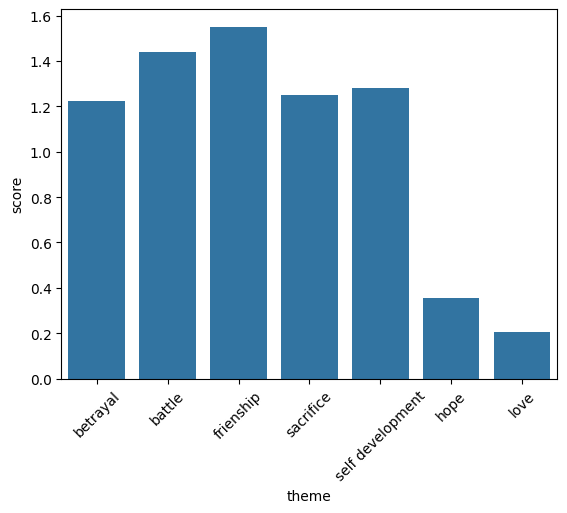

In [62]:
sns.barplot(data = theme_output ,x="theme",y="score" )
plt.xticks(rotation=45)
plt.show()